In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurodsp.sim import sim_bursty_oscillation, sim_oscillation

from timescales.sim import sim_spikes_synaptic, exp_decay_func, sim_acf_cos
from timescales.est import compute_acf, fit_acf, fit_acf_cos, fit_psd

## Manuscript Figures

### Figure 1

Timscale Methods & Applications

- Traditional ACF approach
    - Avg. ACF of population
- Related Errors
    - Bias (Bayes paper) <- need to implement
        - Limits event-related application
        - Multiple Trials (ACF vs Spectral)
    - Oscillations
        - SpecParam
        - ACF + Cos
        
Below, each trace is a separate neuron (equivalent to a separate trial). 100 neurons/trials were simulated, each with 2s of signal, simulating an event-related design.

In [2]:
# Settings
n_seconds = 2
fs = 1000
tau = 0.025
var_noise = None
n_trials = 100 # could also be interpreted as independent neurons

# Simulate Spikes
spikes = np.zeros((n_trials, int(n_seconds * fs)))
spikes_osc = np.zeros((n_trials, int(n_seconds * fs)))

for i in range(n_trials):
    
    _probs, _spikes = sim_spikes_synaptic(n_seconds, fs, tau, n_neurons=1,
                                          mu=10, var_noise=var_noise, return_sum=False)
    
    #_cos = sim_bursty_oscillation(n_seconds, fs, 10, phase='max', burst_def='durations', 
    #                              burst_params=dict(n_cycles_burst=2, n_cycles_off=1))
    _cos = sim_oscillation(n_seconds, fs, 10, phase='max')
    
    spikes[i] = _probs
    
    # Add oscillation
    _cos -= _cos.min()
    _cos /= _cos.max()
    
    spikes_osc[i] = _probs + (_cos * .25)
    spikes_osc[i] = spikes_osc[i] / np.max(spikes_osc[i])
    
# Compute ACF
corrs = compute_acf(spikes, 500)
params_acf = fit_acf(corrs)
params_acf_mean = fit_acf(corrs.mean(axis=0))

corrs_osc = compute_acf(spikes_osc, 500)
params_acf_osc = fit_acf_cos(corrs_osc, fs)
params_acf_mean_osc = fit_acf_cos(corrs_osc.mean(axis=0), fs)

# Fit Spectra
f_range = (1, 80)
fooof_init = {'max_n_peaks': 0}

fg, knee_freq, knee_tau = fit_psd(spikes, fs, f_range, fooof_init)
fg_mean, knee_freq_mean, knee_tau_mean = fit_psd(spikes, fs, f_range, fooof_init, mode='mean')

fooof_init = {'max_n_peaks': 1}
fg_osc, knee_freq_osc, knee_tau_osc = fit_psd(spikes_osc, fs, f_range, fooof_init)
fg_mean_osc, knee_freq_mean_osc, knee_tau_mean_osc = fit_psd(spikes_osc, fs, f_range, fooof_init, mode='mean')

/home/voytek/projects/timescale-methods/.env/lib/python3.8/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/voytek/projects/timescale-methods/.env/lib/python3.8/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/voytek/projects/timescale-methods/.env/lib/python3.8/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/voytek/projects/timescale-methods/.env/lib/python3.8/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)
/home/voytek/projects/timescale-methods/.env/lib/python3.8/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


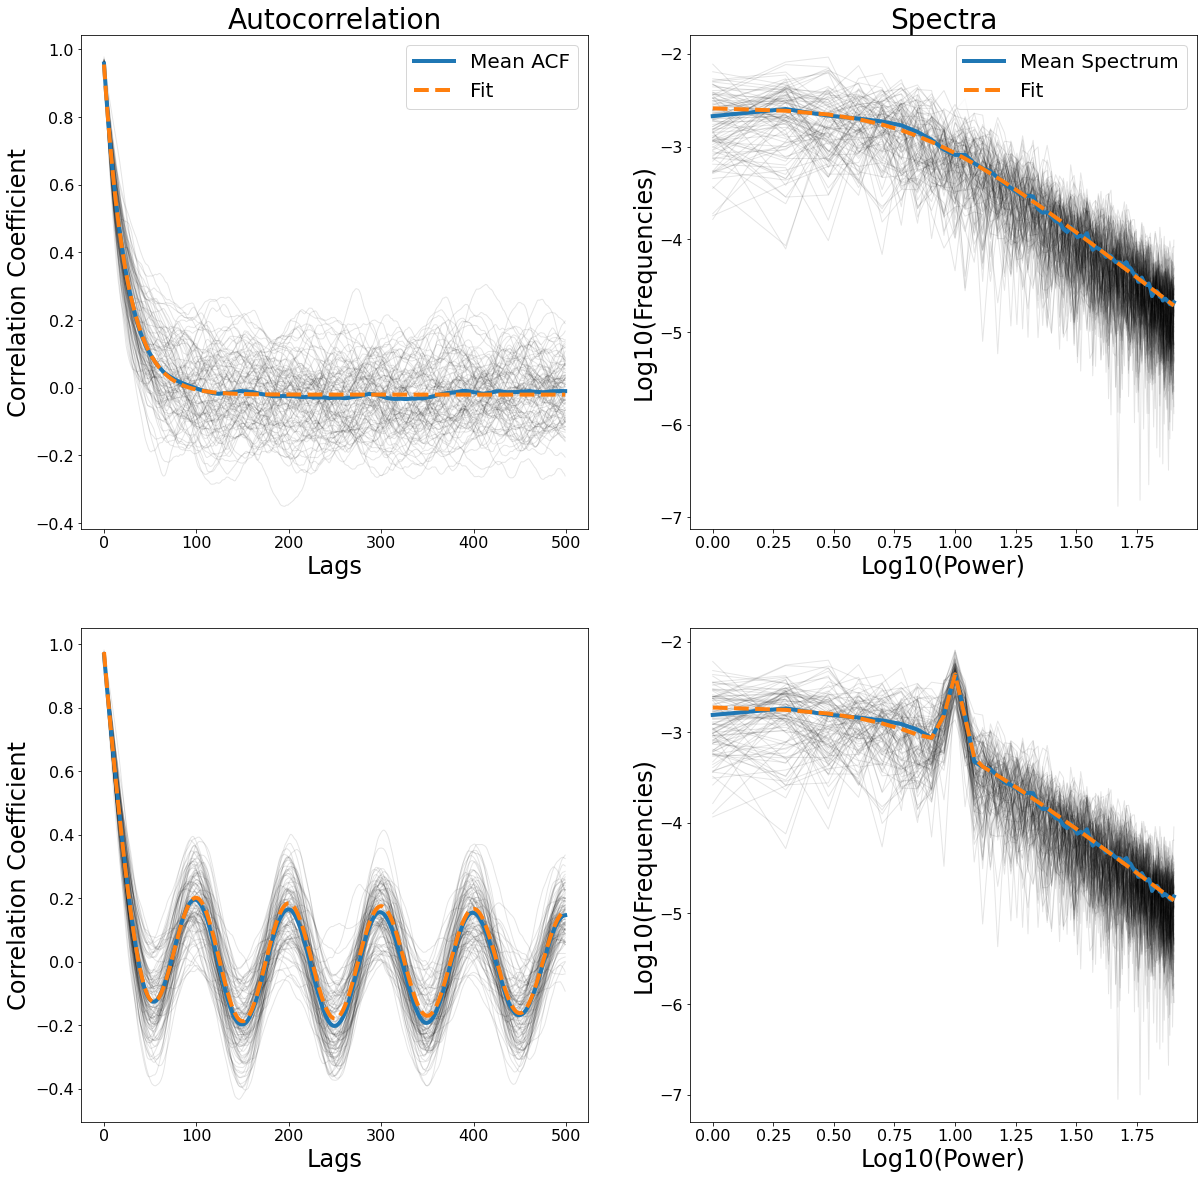

In [3]:
# Plot ACF
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

for ind, c in enumerate(corrs):
    axes[0][0].plot(c, color='k', alpha=.1, lw=1)
for ind, c in enumerate(corrs_osc):
    axes[1][0].plot(c, color='k', alpha=.1, lw=1)
    
axes[0][0].plot(corrs.mean(axis=0), label=f'Mean ACF', lw=4)
axes[1][0].plot(corrs_osc.mean(axis=0), label=f'Mean ACF', lw=4)


axes[0][0].set_xlabel('Lags', fontsize=24)
axes[1][0].set_xlabel('Lags', fontsize=24)
axes[0][0].set_ylabel('Correlation Coefficient', fontsize=24)
axes[1][0].set_ylabel('Correlation Coefficient', fontsize=24)
     
axes[0][0].tick_params(axis='x', labelsize=16)
axes[0][1].tick_params(axis='x', labelsize=16)
axes[1][0].tick_params(axis='x', labelsize=16)
axes[1][1].tick_params(axis='x', labelsize=16)
axes[0][0].tick_params(axis='y', labelsize=16)
axes[0][1].tick_params(axis='y', labelsize=16)
axes[1][0].tick_params(axis='y', labelsize=16)
axes[1][1].tick_params(axis='y', labelsize=16)

# Plot Spectra
for p in fg.power_spectra:
    axes[0][1].plot(np.log10(fg.freqs), p, color='k', alpha=.1, lw=1)
    
for p in fg_osc.power_spectra:
    axes[1][1].plot(np.log10(fg_osc.freqs), p, color='k', alpha=.1, lw=1)
    
axes[0][1].plot(np.log10(fg.freqs), np.log10(np.mean(10**fg.power_spectra, axis=0)), lw=4, color='C0', label='Mean Spectrum')
axes[0][1].set_xlabel('Log10(Power)', fontsize=24)
axes[0][1].set_ylabel('Log10(Frequencies)', fontsize=24)


axes[1][1].plot(np.log10(fg_osc.freqs), np.log10(np.mean(10**fg_osc.power_spectra, axis=0)), lw=4, color='C0', label='Mean Spectrum')
axes[1][1].set_xlabel('Log10(Power)', fontsize=24)
axes[1][1].set_ylabel('Log10(Frequencies)', fontsize=24);

axes[0][0].set_title('Autocorrelation', fontsize=28)
axes[0][1].set_title('Spectra', fontsize=28);

# Plt fits
acf_fit = exp_decay_func(np.arange(1, len(corrs[0])+1), *params_acf_mean)
acf_cos_fit = sim_acf_cos(np.arange(1, len(corrs[0])+1), fs, *params_acf_mean_osc)

axes[0][0].plot(acf_fit, label='Fit', color='C1', lw=4, ls='--')
axes[0][1].plot(np.log10(fg_mean.freqs), fg_mean.fooofed_spectrum_, label='Fit', color='C1', lw=4, ls='--')
axes[1][0].plot(acf_cos_fit, color='C1', lw=4, ls='--')
axes[1][1].plot(np.log10(fg_mean_osc.freqs), fg_mean_osc.fooofed_spectrum_, color='C1', lw=4, ls='--')


axes[0][0].legend(fontsize=20, loc='upper right')
axes[0][1].legend(fontsize=20, loc='upper right')
#plt.savefig('fig1.png')

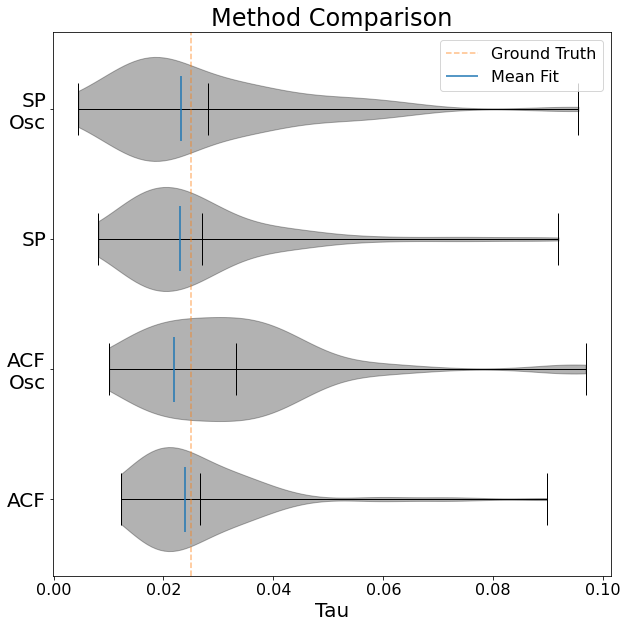

In [4]:
plt.figure(figsize=(10, 10))
_taus = params_acf[:, 1]/fs
inds = np.where((~np.isnan(_taus)) & (_taus > 0) & (_taus < .1))[0]
_taus_acf = _taus[inds]

_taus = params_acf_osc[:, 1]
inds = np.where((~np.isnan(_taus)) & (_taus > 0) & (_taus < .1))[0]
_taus_acf_osc = _taus[inds]

inds = np.where((~np.isnan(knee_tau)) & (knee_tau > 0) & (knee_tau < .1))[0]
_taus_spec = knee_tau[inds]

inds = np.where((~np.isnan(knee_tau_osc)) & (knee_tau_osc > 0) & (knee_tau_osc < .1))[0]
_taus_spec_osc = knee_tau_osc[inds]

violin_parts = plt.violinplot([_taus_acf, _taus_acf_osc, _taus_spec, _taus_spec_osc],
                               showmeans=True, widths=.8, vert=False)
# Colors
for pc in violin_parts['bodies']:
    pc.set_facecolor('k')
    pc.set_edgecolor('k')

for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin_parts[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(1)
        
plt.vlines(knee_tau_mean_osc, ymin=3.75, ymax=4.25, color='C0', alpha=1, label='Mean Fit')
plt.vlines(knee_tau_mean, ymin=2.75, ymax=3.25, color='C0', alpha=1)
plt.vlines(params_acf_mean_osc[1], ymin=1.75, ymax=2.25, color='C0', alpha=1)
plt.vlines(params_acf_mean[1]/fs, ymin=0.75, ymax=1.25, color='C0', alpha=1)

plt.axvline(tau, color='C1', alpha=.5, ls='--', label='Ground Truth')
plt.yticks([1, 2, 3, 4], ['ACF', 'ACF\nOsc', 'SP', 'SP\nOsc'], size=20)
plt.xlabel('Tau', size=20)
plt.tick_params(axis='x', labelsize=16)
plt.title('Method Comparison', size=24)
plt.legend(fontsize=16)
plt.savefig('fig3.png')

### Figure 2

Ground Truth Simulations

- Explain the Convolution + Sampling Method
- Show that methods recapitulate ground truth

### Figure 3

Performance of Different Methods

Function of:

- Amount of data (time & number of neurons)
- Oscillatiory Features
- Short vs Long Tau

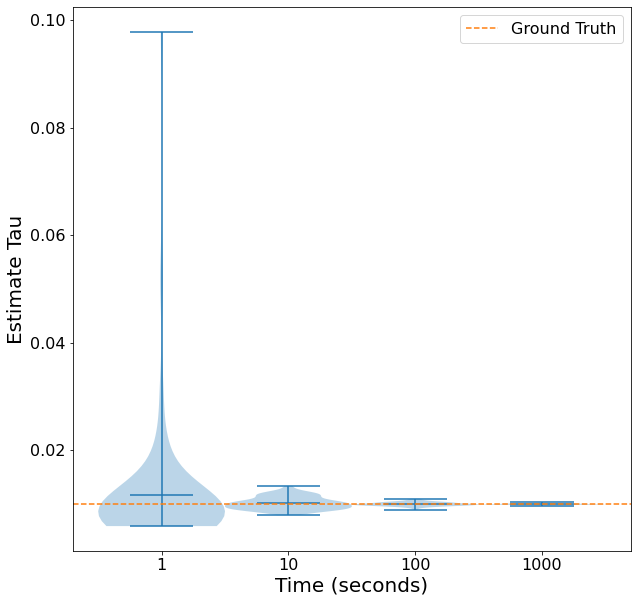

In [5]:
# Settings
fs = 1000
tau = 0.01
var_noise = 0

# Simulate Spikes
n_seconds = np.array([1, 10, 100, 1000])

params = np.zeros((len(n_seconds), 100))
for i in range(len(n_seconds)):
    
    for j in range(100):
        _probs, _spikes = sim_spikes_synaptic(n_seconds[i], fs, tau, n_neurons=1, return_sum=True)
        
        # Compute ACF
        corrs = compute_acf(_probs, 500)
        
        _params = fit_acf(corrs)

        params[i, j] = _params[1] / fs
        
# Plot
fig, ax = plt.subplots(figsize=(10, 10))

ax.violinplot([p for p in params], showmeans=True, widths=1)

ax.axhline(.01, label='Ground Truth', ls='--', color='C1')

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(labels=['1', '10', '100', '1000'])

ax.set_xlabel('Time (seconds)', size=20)
ax.set_ylabel('Estimate Tau', size=20)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.legend(fontsize=16);

### Figure 4

Proposed Workflow